In [1]:
Threads.nthreads()

1

In [3]:
using LinearAlgebra
using Statistics
using IterativeSolvers
using Convex
using SCS
using COSMO
using NLsolve
using DifferentialEquations
using SparseArrays
using Random
using GraphPlot
using MathOptInterface

using JLD2

using LightGraphs
using PyPlot
PyPlot.svg(true);

In [72]:
n = 1
m = 15
# e = 50

# g = complete_bipartite_graph(n, m)

g = LightGraphs.grid([n, m], periodic=true)
N = nv(g)
# add_edge!(g, (1, 2))
# add_edge!(g, (3, 2))

# balanced power flows/natural frequencies
ω = randn(nv(g))
ω .-= mean(ω)
ω = ω./std(ω);

is_connected(g)

true

In [73]:
function optimize_graph(g, K, ω; max_iter=200000, iterations=10000)
    N = nv(g)

    E = incidence_matrix(g; oriented=true)

    # coupling constants
    B = (K/mean(LightGraphs.degree(g)))*ones(ne(g));

    # laplacian
    L = Symmetric(E*diagm(0=>B)*E')

    # u, Q = eigen(L)

    L_sp = dropzeros(sparse(L))

    function f_steady_state(F, δ)
        F .= ω - E*(B.*sin.(E'*δ))
    end

    # initial condition
    δ0 = 1e-2randn(nv(g))
    sln = nlsolve(f_steady_state, δ0; autodiff=:forward, iterations=iterations)

    # order parameter at the fixed point
    R0 = abs2(mean(exp.(1im*sln.zero)))

    # check by solving ODE
    function f_kuramoto(du, u, p, t)
        f_steady_state(du, u)
    end

    # Noisy extension
    δbar = sln.zero
    
    if converged(sln)
        # construct S matrix
        h = complete_graph(nv(g))
        Eh = incidence_matrix(h; oriented=true)
        cosδbar = cos.(Eh'*δbar)
        # cosδbar = ones(ne(h))

        # Laplacian of the corresponding complete graph
        S = Symmetric(-Eh*diagm(0=>cosδbar)*Eh'/nv(g)^2)

        # weighted Laplacian expanded around fixed point
        B_fp = cos.(E'*δbar).*B
        L_fp = Symmetric(E*diagm(0 => B_fp)*E')

        # optimize!
        Eq = Convex.Semidefinite(nv(g))
        C = Convex.Semidefinite(nv(g))

        problem = maximize(tr(S*Eq), [
                L_fp*Eq + Eq*L_fp == C, 
                Eq*ones(N) == zeros(N),
        #         sum(Eq) == 0.0,
                diag(C, 0) == 1.0,
        #         tr(C) == nv(g),
                ])

        Convex.solve!(problem, () -> COSMO.Optimizer(verbose=false, 
                eps_abs=1e-7, eps_rel=1e-7, max_iter=max_iter))

        @show R0, converged(sln)
        @show problem.optval, problem.status
    end
    
    if converged(sln) && (problem.status == MathOptInterface.OPTIMAL)
        C.value, Eq.value, S, L_fp, R0, problem.optval, δbar, B, E
    else
        [NaN], [NaN], [NaN], [NaN], NaN, NaN, [NaN], B, E
    end
end

optimize_graph (generic function with 1 method)

In [74]:
K = 2.0
Copt, Eopt, S, L_fp, R0, optval, δbar, B, E = optimize_graph(g, K, ω)

C_unif = ((1 + 1/nv(g))I - ones(nv(g), nv(g))/nv(g))

15×15 Matrix{Float64}:
  1.0        -0.0666667  -0.0666667  …  -0.0666667  -0.0666667  -0.0666667
 -0.0666667   1.0        -0.0666667     -0.0666667  -0.0666667  -0.0666667
 -0.0666667  -0.0666667   1.0           -0.0666667  -0.0666667  -0.0666667
 -0.0666667  -0.0666667  -0.0666667     -0.0666667  -0.0666667  -0.0666667
 -0.0666667  -0.0666667  -0.0666667     -0.0666667  -0.0666667  -0.0666667
 -0.0666667  -0.0666667  -0.0666667  …  -0.0666667  -0.0666667  -0.0666667
 -0.0666667  -0.0666667  -0.0666667     -0.0666667  -0.0666667  -0.0666667
 -0.0666667  -0.0666667  -0.0666667     -0.0666667  -0.0666667  -0.0666667
 -0.0666667  -0.0666667  -0.0666667     -0.0666667  -0.0666667  -0.0666667
 -0.0666667  -0.0666667  -0.0666667     -0.0666667  -0.0666667  -0.0666667
 -0.0666667  -0.0666667  -0.0666667  …  -0.0666667  -0.0666667  -0.0666667
 -0.0666667  -0.0666667  -0.0666667     -0.0666667  -0.0666667  -0.0666667
 -0.0666667  -0.0666667  -0.0666667      1.0        -0.0666667  -0.0666667
 -

In [75]:
function optimize_at_std(Ks, σ_ω)
    # run a set of optimizations at a fixed value of the standard deviation
    Cvals = []
    Copts = []
    optvals = []
    R0s = []
    δbars = []

    cur_g = g
    for (i, k) in enumerate(Ks)
        Copt, Eopt, S, L_fp, R0, optval, δbar, B, E = optimize_graph(cur_g, k, σ_ω*ω; iterations=5000, max_iter=200000)

        push!(Copts, Copt)
        push!(Cvals, sum(abs.(Copt))/N^2)
        push!(optvals, optval)
        push!(R0s, R0)
        push!(δbars, δbar)
    end
    
    Cvals, Copts, optvals, R0s, δbars
end

optimize_at_std (generic function with 1 method)

In [76]:
σ_ωs = 10.0.^LinRange(-2, -1, 10)
Ks = LinRange(0.01, 1.0, 201)

optvals_all = []
R0s_all = []

for σ_ω in σ_ωs
    Cvals, Copts, optvals, R0s, δbars = optimize_at_std(Ks, σ_ω)
    
    push!(optvals_all, optvals)
    push!(R0s_all, R0s)
end

(R0, converged(sln)) = (0.303321470183569, true)
(problem.optval, problem.status) = (55.06061877051714, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.42793056404990637, true)
(problem.optval, problem.status) = (12.925462471242868, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.5189001454590065, true)
(problem.optval, problem.status) = (-0.862010637985005, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.5898514976279976, true)
(problem.optval, problem.status) = (-2.735701873067708, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.6464489710368149, true)
(problem.optval, problem.status) = (-2.720103238095533, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.6923011435069257, true)
(problem.optval, problem.status) = (-2.6719924976809, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.7299280171536813, true)
(problem.optval, problem.status) = (-2.605620813172827, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.7611560767742537, true)
(problem.optval, problem.stat

(R0, converged(sln)) = (0.9913607880345033, true)
(problem.optval, problem.status) = (-0.5892126374973029, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9915579164629398, true)
(problem.optval, problem.status) = (-0.5825409770688773, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9917483771402738, true)
(problem.optval, problem.status) = (-0.5760176059472636, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9919324672831227, true)
(problem.optval, problem.status) = (-0.5696376726975251, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9921104693370203, true)
(problem.optval, problem.status) = (-0.5633964896356704, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9922826440511633, true)
(problem.optval, problem.status) = (-0.557289653016574, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9924492474526689, true)
(problem.optval, problem.status) = (-0.551312877275807, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9926105157839871, true)
(problem.optval, prob

(R0, converged(sln)) = (0.9975919887501619, true)
(problem.optval, problem.status) = (-0.3125834324549615, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9976212496396855, true)
(problem.optval, problem.status) = (-0.31068549412111546, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9976499804785726, true)
(problem.optval, problem.status) = (-0.3088104149634082, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.997678193989861, true)
(problem.optval, problem.status) = (-0.30695778326458056, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9977059025433012, true)
(problem.optval, problem.status) = (-0.30512721731611814, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9977331180422527, true)
(problem.optval, problem.status) = (-0.3033183066794862, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9977598521869218, true)
(problem.optval, problem.status) = (-0.30153066457717664, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9977861162364716, true)
(problem.optval,

(R0, converged(sln)) = (0.9558971752224862, true)
(problem.optval, problem.status) = (-1.0021870695479014, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9576300692181773, true)
(problem.optval, problem.status) = (-0.9836736366560839, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9592630437398276, true)
(problem.optval, problem.status) = (-0.9657997523665803, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.960803603201172, true)
(problem.optval, problem.status) = (-0.9485348816212242, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9622585953392786, true)
(problem.optval, problem.status) = (-0.9318502774970024, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9636342190764601, true)
(problem.optval, problem.status) = (-0.9157187680753778, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9649361309064063, true)
(problem.optval, problem.status) = (-0.9001147071493925, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9661694977062577, true)
(problem.optval, pro

(problem.optval, problem.status) = (-0.40285995971878746, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.993388445763154, true)
(problem.optval, problem.status) = (-0.39972467771592013, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9934912162670829, true)
(problem.optval, problem.status) = (-0.3966375237989748, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9935916099214503, true)
(problem.optval, problem.status) = (-0.39359740202205423, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9936896994438844, true)
(problem.optval, problem.status) = (-0.3906032914416443, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9937855555654154, true)
(problem.optval, problem.status) = (-0.38765412078779554, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9938792432305955, true)
(problem.optval, problem.status) = (-0.384748922958956, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.993970829615592, true)
(problem.optval, problem.status) = (-0.38188670323210516, MathOptInt

(problem.optval, problem.status) = (33.834893011849125, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.3817569508669031, true)
(problem.optval, problem.status) = (15.002653953802028, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.44647376790326765, true)
(problem.optval, problem.status) = (5.426134726781833, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.5010891225499811, true)
(problem.optval, problem.status) = (0.5214707300482893, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.5480006861762589, true)
(problem.optval, problem.status) = (-1.6299203914452502, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.5886878490585199, true)
(problem.optval, problem.status) = (-1.6399208566367043, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.6242236103808918, true)
(problem.optval, problem.status) = (-1.6376128120291407, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.6554383307520306, true)
(problem.optval, problem.status) = (-1.6265854754760936, MathOptInterface

(R0, converged(sln)) = (0.9794849620379465, true)
(problem.optval, problem.status) = (-0.5392721250107213, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.979917530083217, true)
(problem.optval, problem.status) = (-0.5337383288558047, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9803365752193385, true)
(problem.optval, problem.status) = (-0.5283147797626402, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9807426547582, true)
(problem.optval, problem.status) = (-0.5229982255717347, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.981136297319733, true)
(problem.optval, problem.status) = (-0.5177856222597884, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9815180043409739, true)
(problem.optval, problem.status) = (-0.5126741223214291, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9818882542678362, true)
(problem.optval, problem.status) = (-0.5076606675449004, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.982247500258815, true)
(problem.optval, problem.

(R0, converged(sln)) = (0.993843917526931, true)
(problem.optval, problem.status) = (-0.29874733275861015, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9939156243038666, true)
(problem.optval, problem.status) = (-0.2970188591986587, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9939860858961607, true)
(problem.optval, problem.status) = (-0.2953101788267011, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9940553309578606, true)
(problem.optval, problem.status) = (-0.29362093273442563, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9941233873220884, true)
(problem.optval, problem.status) = (-0.29195079486585535, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9941902820330819, true)
(problem.optval, problem.status) = (-0.2902994566828388, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9942560413712805, true)
(problem.optval, problem.status) = (-0.2886665905510359, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9943206908760955, true)
(problem.optval, 

(R0, converged(sln)) = (0.9261387436588887, true)
(problem.optval, problem.status) = (-0.7587842305154148, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9283993611308211, true)
(problem.optval, problem.status) = (-0.748486004305831, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9305581921455401, true)
(problem.optval, problem.status) = (-0.7384354543661885, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.932621242577737, true)
(problem.optval, problem.status) = (-0.7286253156979657, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.934594043874201, true)
(problem.optval, problem.status) = (-0.7190486329088877, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9364818130342496, true)
(problem.optval, problem.status) = (-0.7096983802832652, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9382892847128798, true)
(problem.optval, problem.status) = (-0.7005677876587303, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9400209696385414, true)
(problem.optval, probl

(R0, converged(sln)) = (0.9848827066991426, true)
(problem.optval, problem.status) = (-0.3599483501714548, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.985095795860849, true)
(problem.optval, problem.status) = (-0.35746218164555227, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9853044147112435, true)
(problem.optval, problem.status) = (-0.3550096830583524, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9855086876639433, true)
(problem.optval, problem.status) = (-0.3525900696033387, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.985708734195959, true)
(problem.optval, problem.status) = (-0.3502028084700442, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9859046702408591, true)
(problem.optval, problem.status) = (-0.3478472461251199, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9860966077009062, true)
(problem.optval, problem.status) = (-0.3455227015521195, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.986284653842746, true)
(problem.optval, prob

(R0, converged(sln)) = (0.6770136402959797, true)
(problem.optval, problem.status) = (-0.9673915652473335, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.692422430942611, true)
(problem.optval, problem.status) = (-0.9602027137765815, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.7067760205249909, true)
(problem.optval, problem.status) = (-0.9521858354656625, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.7201668157065085, true)
(problem.optval, problem.status) = (-0.9435042178501792, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.7326774605962443, true)
(problem.optval, problem.status) = (-0.9342948390698977, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.7443820474460257, true)
(problem.optval, problem.status) = (-0.9246726943695234, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.7553471544512381, true)
(problem.optval, problem.status) = (-0.9147344687567299, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.7656327345052263, true)
(problem.optval, pro

(problem.optval, problem.status) = (-0.42974611015823866, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9634078786812845, true)
(problem.optval, problem.status) = (-0.426282412205472, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9640267134644006, true)
(problem.optval, problem.status) = (-0.422871874544594, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9646300138479104, true)
(problem.optval, problem.status) = (-0.41951332761407933, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9652182926795602, true)
(problem.optval, problem.status) = (-0.41620568987104656, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9657920450517508, true)
(problem.optval, problem.status) = (-0.4129478323188822, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9663517461826456, true)
(problem.optval, problem.status) = (-0.40973871442036375, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9668978493523915, true)
(problem.optval, problem.status) = (-0.4065772871360819, MathOptInt

(problem.optval, problem.status) = (-0.2628620699686581, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.986725730553862, true)
(problem.optval, problem.status) = (-0.26153168078970307, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9868619024007684, true)
(problem.optval, problem.status) = (-0.26021449724054196, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9869959911746609, true)
(problem.optval, problem.status) = (-0.2589103372109067, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9871280390970307, true)
(problem.optval, problem.status) = (-0.2576190510784432, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9872580873818937, true)
(problem.optval, problem.status) = (-0.2563404680555581, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.987386176106872, true)
(problem.optval, problem.status) = (-0.25507429978043095, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9875123444743585, true)
(problem.optval, problem.status) = (-0.2538204488449129, MathOptInte

(R0, converged(sln)) = (0.9168894271611341, true)
(problem.optval, problem.status) = (-0.47880685278287627, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.918519251455116, true)
(problem.optval, problem.status) = (-0.47473720764965177, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9201018408465198, true)
(problem.optval, problem.status) = (-0.47072758356327127, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9216389873477838, true)
(problem.optval, problem.status) = (-0.46677683236578105, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9231324056305639, true)
(problem.optval, problem.status) = (-0.4628840373301183, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9245837493694095, true)
(problem.optval, problem.status) = (-0.4590482634466281, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9259945341376191, true)
(problem.optval, problem.status) = (-0.45526848244545765, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.927366269015821, true)
(problem.optval,

(R0, converged(sln)) = (0.9734348780612195, true)
(problem.optval, problem.status) = (-0.2834768832017826, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9737328040699347, true)
(problem.optval, problem.status) = (-0.28194937376051094, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9740257548510314, true)
(problem.optval, problem.status) = (-0.28043781041897176, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9743138388606201, true)
(problem.optval, problem.status) = (-0.2789419464207743, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9745971654265246, true)
(problem.optval, problem.status) = (-0.2774615264008981, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.974875835202927, true)
(problem.optval, problem.status) = (-0.275996361741004, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9751499497709644, true)
(problem.optval, problem.status) = (-0.2745461598998907, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9754196117610292, true)
(problem.optval, pr

(R0, converged(sln)) = (0.8382558238260301, true)
(problem.optval, problem.status) = (-0.4827661792547168, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.8416524409508201, true)
(problem.optval, problem.status) = (-0.47915211204306063, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.844944265683548, true)
(problem.optval, problem.status) = (-0.47556562498630556, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.8481355184616726, true)
(problem.optval, problem.status) = (-0.4720078971472233, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.8512302118234537, true)
(problem.optval, problem.status) = (-0.46847989385661465, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.8542321627676319, true)
(problem.optval, problem.status) = (-0.46498243874121603, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.8571450020804522, true)
(problem.optval, problem.status) = (-0.4615163140416064, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.8599722026686306, true)
(problem.optval,

(R0, converged(sln)) = (0.9515523001793461, true)
(problem.optval, problem.status) = (-0.29125350487205104, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9521191085797089, true)
(problem.optval, problem.status) = (-0.2896777028629652, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9526760556371643, true)
(problem.optval, problem.status) = (-0.28811788770835056, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9532233701729016, true)
(problem.optval, problem.status) = (-0.28657383331897834, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9537612676754719, true)
(problem.optval, problem.status) = (-0.2850453203163978, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9542899672319595, true)
(problem.optval, problem.status) = (-0.2835321600197149, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9548096748999709, true)
(problem.optval, problem.status) = (-0.28203406940568365, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9553205920760222, true)
(problem.optval

(R0, converged(sln)) = (0.7512647707700971, true)
(problem.optval, problem.status) = (-0.42634930589098347, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.7562393540515793, true)
(problem.optval, problem.status) = (-0.4241879993089646, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.7610686106093835, true)
(problem.optval, problem.status) = (-0.4220039236962795, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.7657581035668399, true)
(problem.optval, problem.status) = (-0.4198003613486022, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.7703130598746226, true)
(problem.optval, problem.status) = (-0.4175803146398263, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.7747384978017584, true)
(problem.optval, problem.status) = (-0.41534659166881993, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.779039196073575, true)
(problem.optval, problem.status) = (-0.41310175350573286, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.7832197278497233, true)
(problem.optval, 

(R0, converged(sln)) = (0.922396614835615, true)
(problem.optval, problem.status) = (-0.27864555257774465, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9232841173089714, true)
(problem.optval, problem.status) = (-0.2772528161883494, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9241565330076453, true)
(problem.optval, problem.status) = (-0.2758723396705329, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9250142392562082, true)
(problem.optval, problem.status) = (-0.2745039900988745, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9258575297446325, true)
(problem.optval, problem.status) = (-0.2731476548675819, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9266867453090644, true)
(problem.optval, problem.status) = (-0.27180318221850475, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9275021892794918, true)
(problem.optval, problem.status) = (-0.2704704892825602, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9283041662184837, true)
(problem.optval, p

(R0, converged(sln)) = (0.7100439719049025, true)
(problem.optval, problem.status) = (-0.3414756964124552, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.7148826779472249, true)
(problem.optval, problem.status) = (-0.3403601515234262, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.7196036346084937, true)
(problem.optval, problem.status) = (-0.3392177574536763, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.724210567442273, true)
(problem.optval, problem.status) = (-0.33805070861248515, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.7287070304701356, true)
(problem.optval, problem.status) = (-0.3368609878531153, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.7330964402429379, true)
(problem.optval, problem.status) = (-0.3356505429991678, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.737382155822804, true)
(problem.optval, problem.status) = (-0.33442116353684803, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.7415673109531014, true)
(problem.optval, pr

(R0, converged(sln)) = (0.8945587467202034, true)
(problem.optval, problem.status) = (-0.24562251124100548, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.8956451332259605, true)
(problem.optval, problem.status) = (-0.2445819595855721, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.8967149254259215, true)
(problem.optval, problem.status) = (-0.2435484512995546, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.8977684572600266, true)
(problem.optval, problem.status) = (-0.24252197297353162, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.8988060543676112, true)
(problem.optval, problem.status) = (-0.24150246429801248, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.8998280343406383, true)
(problem.optval, problem.status) = (-0.24048990788312666, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9008347069536122, true)
(problem.optval, problem.status) = (-0.23948426243807797, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.9018263744078979, true)
(problem.optva

(R0, converged(sln)) = (0.7293057237502527, true)
(problem.optval, problem.status) = (-0.26069361428034943, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.732702452508897, true)
(problem.optval, problem.status) = (-0.25996769740112974, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.7360368270109896, true)
(problem.optval, problem.status) = (-0.25923292448989677, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.7393103349809952, true)
(problem.optval, problem.status) = (-0.2584899024160002, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.7425244208666497, true)
(problem.optval, problem.status) = (-0.25773921729672267, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.7456804873021353, true)
(problem.optval, problem.status) = (-0.2569814484498846, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.7487798963255368, true)
(problem.optval, problem.status) = (-0.2562170974967127, MathOptInterface.OPTIMAL)
(R0, converged(sln)) = (0.751823971228058, true)
(problem.optval, 

┌ Warning: Problem status ITERATION_LIMIT; solution may be inaccurate.
└ @ Convex /home/hmr1/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status ITERATION_LIMIT; solution may be inaccurate.
└ @ Convex /home/hmr1/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status ITERATION_LIMIT; solution may be inaccurate.
└ @ Convex /home/hmr1/.julia/packages/Convex/uI27T/src/solution.jl:263


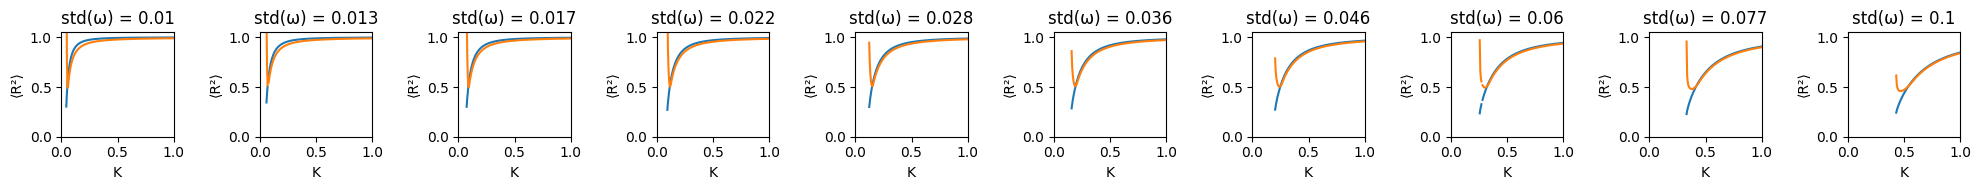

In [77]:
fig, axs = subplots(1, length(σ_ωs), figsize=(2*length(σ_ωs), 2))

σ = 0.25
for (ax, optvals, R0s, σ_ω) in zip(axs, optvals_all, R0s_all, σ_ωs)
    ax.plot(Ks, R0s, label="noise-free")
    ax.plot(Ks, R0s .+ 0.5*(σ^2)*optvals, label="optimized noise")
    ax.set_xlabel("K")
    ax.set_ylabel("⟨R²⟩")
    ax.set_ylim(0, 1.05)
    ax.set_xlim(0, 1.0)
    ax.set_title("std(ω) = $(round(σ_ω, sigdigits=2))")
end

fig.tight_layout()

In [78]:
jldsave("data/chain_omegas_n_$(n)_m_$(m).jld2"; g, Ks, optvals_all, R0s_all, σ_ωs)